In [1]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')

import pyrcel as pm
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Fixed
P0 = 77500. # Pressure, Pa
T0 = 274.   # Temperature, K
S0 = -0.05  # Supersaturation, 1-RH (98% here)

from pyrcel import binned_activation

Vs = np.arange(10, 80, 20, dtype=float) #np.arange(0.1, 1.0, 0.1, dtype=float) #np.logspace(-1, np.log10(10,), 11)[::-1] # 0.1 - 5.0 m/s
accom = 0.1

smaxes, act_fracs = [], []
aers = []
for V in Vs:

    aer =  pm.AerosolSpecies('ammonium sulfate',
                          pm.Lognorm(mu=0.05, sigma=2.0, N=V),
                          kappa=0.7, bins=100)
    
    aers.append(aer)
    
    # Initialize the model
    V_updraft = 1.0
    model = pm.ParcelModel([aer,], V_updraft, T0, S0, P0, accom=accom, console=False)
    par_out, aer_out = model.run(t_end=250., dt=1.0, solver='cvode',
                                 output='dataframes', terminate=False)
    
    #model.set_initial_conditions()

    print(V, par_out.S.max())

    # Extract the supersaturation/activation details from the model
    # output
    S_max = par_out['S'].max()
    time_at_Smax = par_out['S'].argmax()

    #if time_at_Smax == 90 or time_at_Smax == 840:
    #    continue

    #print(S_max, time_at_Smax)
    #print(aer_out['ammonium sulfate'].keys())
    
    print('*****Here: ', S_max, time_at_Smax, aer_out['ammonium sulfate'])#.loc[time_at_Smax])#.iloc[0])

    # wet_sizes_at_Smax = aer_out['ammonium sulfate'].ix[time_at_Smax].iloc[0]
    wet_sizes_at_Smax = aer_out['ammonium sulfate'].loc[time_at_Smax].iloc[0]
    #print('wet_sizes_at_Smax', wet_sizes_at_Smax)
    
    wet_sizes_at_Smax = np.array(wet_sizes_at_Smax.tolist())

    frac_eq, _, _, _ = binned_activation(S_max, T0, wet_sizes_at_Smax, aer)

    # Save the output
    smaxes.append(S_max)
    act_fracs.append(frac_eq)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


10.0 0.01923256807749215
*****Here:  0.01923256807749215 158                r000          r001          r002          r003          r004  \
0.0    3.464587e-09  3.736966e-09  4.031473e-09  4.349797e-09  4.693730e-09   
1.0    3.465941e-09  3.738565e-09  4.033358e-09  4.352012e-09  4.696329e-09   
2.0    3.467298e-09  3.740168e-09  4.035247e-09  4.354235e-09  4.698936e-09   
3.0    3.468658e-09  3.741776e-09  4.037143e-09  4.356464e-09  4.701553e-09   
4.0    3.470022e-09  3.743388e-09  4.039044e-09  4.358701e-09  4.704178e-09   
...             ...           ...           ...           ...           ...   
245.0  3.651802e-09  3.962005e-09  4.301599e-09  4.673598e-09  5.081353e-09   
246.0  3.651538e-09  3.961688e-09  4.301218e-09  4.673140e-09  5.080801e-09   
247.0  3.651277e-09  3.961375e-09  4.300842e-09  4.672689e-09  5.080258e-09   
248.0  3.651021e-09  3.961068e-09  4.300473e-09  4.672245e-09  5.079724e-09   
249.0  3.650768e-09  3.960765e-09  4.300110e-09  4.671808e-09  5.07919

In [3]:
V_updraft = 1.0

smaxes_arg, act_fracs_arg = [], []
smaxes_mbn, act_fracs_mbn = [], []

## change here
Vs_copy = Vs#[:9]

for V in Vs_copy:

    #smax_arg, _, afs_arg = pm.arg2000(V_updraft, T0, P0, accom=accom, kappas=Vs)
    #smax_mbn, _, afs_mbn = pm.mbn2014(V_updraft, T0, P0, accom=accom, kappas=Vs)

    smax_arg, _, afs_arg = pm.arg2000(V_updraft, T0, P0, aers, accom=accom)
    smax_mbn, _, afs_mbn = pm.mbn2014(V_updraft, T0, P0, aers, accom=accom)

    #smax_arg, _, afs_arg = pm.arg2000(V_updraft, T0, P0, [aer], accom=accom)
    #smax_mbn, _, afs_mbn = pm.mbn2014(V_updraft, T0, P0, [aer], accom=accom)

    smaxes_arg.append(smax_arg)
    act_fracs_arg.append(afs_arg[0])
    smaxes_mbn.append(smax_mbn)
    act_fracs_mbn.append(afs_mbn[0])

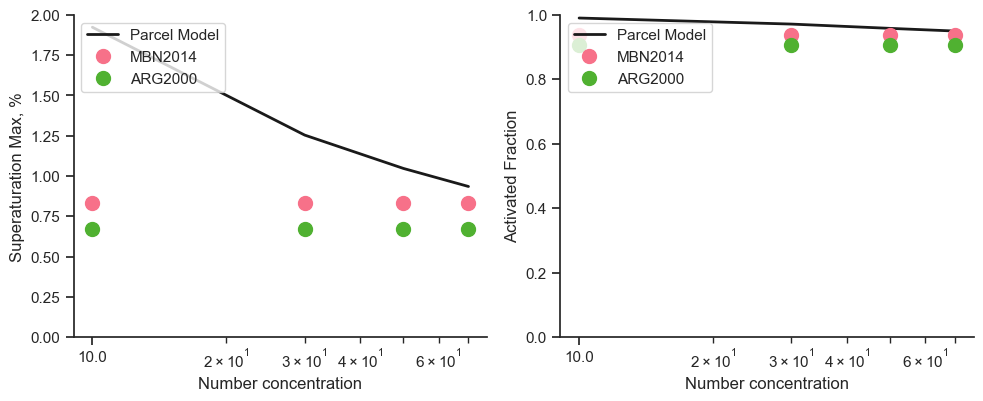

In [4]:
sns.set(context="notebook", style='ticks')
sns.set_palette("husl", 3)
fig, [ax_s, ax_a] = plt.subplots(1, 2, sharex=True, figsize=(10,4))

ax_s.plot(Vs, np.array(smaxes)*100., color='k', lw=2, label="Parcel Model")
ax_s.plot(Vs, np.array(smaxes_mbn)*100., linestyle='None',
          marker="o", ms=10, label="MBN2014" )
ax_s.plot(Vs, np.array(smaxes_arg)*100., linestyle='None',
          marker="o", ms=10, label="ARG2000" )
ax_s.semilogx()
ax_s.set_ylabel("Superaturation Max, %")
ax_s.set_ylim(0, 2.)

ax_a.plot(Vs, act_fracs, color='k', lw=2, label="Parcel Model")
ax_a.plot(Vs, act_fracs_mbn, linestyle='None',
          marker="o", ms=10, label="MBN2014" )
ax_a.plot(Vs, act_fracs_arg, linestyle='None',
          marker="o", ms=10, label="ARG2000" )
ax_a.semilogx()
ax_a.set_ylabel("Activated Fraction")
ax_a.set_ylim(0, 1.)

plt.tight_layout()
sns.despine()

for ax in [ax_s, ax_a]:
    ax.legend(loc='upper left')
    ax.xaxis.set_ticks(list(Vs)[::30])
    ax.xaxis.set_ticklabels(list(Vs)[::30])
    #ax.xaxis.set_ticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    #ax.xaxis.set_ticklabels([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    #ax.set_xlabel("Updraft speed, m/s")
    #ax.set_xlabel("Hygroscopicity/Kappa")
    ax.set_xlabel("Number concentration")